# Summary
A site is considered promising for cobalt if it lies close to both `ultramafic/serpentinite` rocks and `granodioritic` intrusions.

We first identify these two rock families in the geological map using keywords (`ultramafic, serpentinite, dunite, peridotite` / `granodiorite`). Each family is then grouped into a continuous spatial layer.

On a regular grid, we measure the distance from each cell to the nearest unit of each family, and convert it into a proximity score between 0 and 1 (`with 1 at direct contact, and 0 beyond 10 km`).

The final score is the product of the two proximities, which means that only areas close to both rock types achieve high values. The outputs include a GIS-ready GeoTIFF, a PNG map for quick viewing, and a ranked list of hotspot zones to guide cobalt prospecting.

## Importing Libraries and Dependencies


In [2]:
import re
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
from shapely.ops import unary_union
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
INPUT      = r"D:\DS_kokold\DS_Kobold_Takehome_Assignment_Data\Kobold_Takehome_Assignment_Data\BedrockP.gpkg" # Bedrock polygons (GeoPackage)
gdf = gpd.read_file(INPUT)

In [4]:
gdf.head()

,gid,upid,area_m2,strat_unit,era,period,strat_age,strat_name,gp_suite,fm_lithodm,...,terrane,basin,basin_age,project,src_url,src_ref_s,map_comp,edit_date,pub_org,geometry
0,33649.0,9c192ffb,4368828.0,uKPCvl,Mesozoic,Cretaceous,Upper Cretaceous,Powell Creek Formation - upper unit,None,Powell Creek Formation,...,Overlap,None,None,Chilcotin-Bonaparte,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza et al., 1997, Chilcotin-Bonaparte, ...","Schiarizza, 2017, Chicotin-Bonaparte",2018-04-05,British Columbia Geological Survey,"POLYGON ((466212.803 5669781.24, 466385.735 56..."
1,26344.0,824df15e,34431394.0,lKGsv,Mesozoic,Cretaceous,Lower Cretaceous,Gambier Group,Gambier Group,None,...,Overlap,None,None,Mid-coast,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Bellefontaine et al., 1994, Mid-coast, BCGS, O...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((541326.012 5529535.059, 541118.84 55..."
2,29100.0,2f4fa4a6,74490974.0,lKGsv,Mesozoic,Cretaceous,Lower Cretaceous,Gambier Group,Gambier Group,None,...,Overlap,None,None,Mid-coast,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Bellefontaine et al., 1994, Mid-coast, BCGS, O...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((541118.84 5528958.183, 541326.012 55..."
3,18121.0,8c3e4237,28858519.0,JKCsf,Mesozoic,Jurassic to Cretaceous,Jurassic to Cretaceous,Cayoosh assemblage?,Cayoosh assemblage?,None,...,Bridge River,None,None,Okanagan,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza and Church., 1996, Okanagan, BCGS, ...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((508143.471 5601807.482, 508301.595 5..."
4,18113.0,d7681ec3,38898103.0,Mivb,Cenozoic,Neogene,Miocene,None,None,None,...,Younger Volcanics,None,None,Okanagan,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza and Church., 1996, Okanagan, BCGS, ...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((508835.893 5603890.448, 508674.02 56..."


### Quick Data Exploration

This cell provides a first overview of the input GeoDataFrame:
- Lists the available columns  
- Prints the number of polygons (rows)  
- Displays the coordinate reference system (CRS)  
- Shows the dataset bounds (min/max coordinates)  
- Checks for invalid geometries  

In [5]:
print("Available columns:", gdf.columns.tolist())
print("Number of polygons:", len(gdf))
print("CRS:", gdf.crs)
print("Bounds:", gdf.total_bounds)  # (minx, miny, maxx, maxy)
print("Invalid geometries:", (~gdf.is_valid).sum())

Available columns: ['gid', 'upid', 'area_m2', 'strat_unit', 'era', 'period', 'strat_age', 'strat_name', 'gp_suite', 'fm_lithodm', 'mem_phase', 'rock_class', 'rock_type', 'rk_char', 'unit_desc', 'age_max', 'age_min', 'belt', 'terrane', 'basin', 'basin_age', 'project', 'src_url', 'src_ref_s', 'map_comp', 'edit_date', 'pub_org', 'geometry']
Number of polygons: 1596
CRS: EPSG:26910
Bounds: [ 284655.0477908  5479575.39393347  688671.44607798 5935410.66807719]
Invalid geometries: 0


#### Rock Inventory Function

This cell defines a helper function to explore rock-related text columns in the dataset:
- Scans selected columns (e.g., `rock_class`, `rock_type`, `unit_desc`, `strat_name`)  
- Normalizes text (lowercase, trimmed) for consistent values  
- Counts the frequency of each rock name per column  
- Prints the top 10 most frequent values in each column  
- Exports a full inventory to CSV for further inspection  

In [6]:
# Columns to scan (we can adjust it if needed)
ROCK_COLS = ["rock_class", "rock_type", "unit_desc", "strat_name"]

def normalize_text(s: pd.Series) -> pd.Series:
    """Lowercase + trim; keep as-is otherwise (light normalization)."""
    return (
        s.astype(str)
         .str.lower()
         .str.strip()
         .replace({"none": "", "nan": ""})
    )

def rock_inventory(input_path: str, cols=ROCK_COLS, csv_prefix=None):
    gdf = gpd.read_file(input_path)
    if gdf.empty:
        raise RuntimeError("Input file is empty or unreadable.")
    print(f"Rows: {len(gdf)} | CRS: {gdf.crs}")

    existing = [c for c in cols if c in gdf.columns]
    if not existing:
        print("No expected rock text columns found.")
        return None

    # Build a long table of values with counts per column
    frames = []
    for c in existing:
        col_norm = normalize_text(gdf[c].dropna())
        vc = (col_norm[col_norm != ""]
              .value_counts()
              .rename_axis("value")
              .reset_index(name="count"))
        vc.insert(0, "column", c)
        frames.append(vc)

        # Quick on-screen preview (top 15)
        print(f"\n=== Top values in {c} (top 15) ===")
        print(vc.head(15).to_string(index=False))

    inv = pd.concat(frames, ignore_index=True) if frames else None

    # export full inventory per column
    if csv_prefix and inv is not None:
        inv.to_csv(f"{csv_prefix}_rock_inventory.csv", index=False)
        print(f"\nSaved: {csv_prefix}_rock_inventory.csv")

    return inv

In [7]:
inv = rock_inventory(
     input_path=INPUT,
     cols=["rock_class","rock_type","unit_desc","strat_name"],
     csv_prefix=r"D:\DS_kokold\explore_bedrock"
 )

Rows: 1596 | CRS: EPSG:26910

=== Top values in rock_class (top 15) ===
    column             value  count
rock_class sedimentary rocks    556
rock_class   intrusive rocks    455
rock_class    volcanic rocks    435
rock_class metamorphic rocks    104
rock_class  ultramafic rocks     46

=== Top values in rock_type (top 15) ===
   column                                                     value  count
rock_type                               undivided sedimentary rocks    246
rock_type                                  undivided volcanic rocks    149
rock_type                             granodioritic intrusive rocks    147
rock_type                     marine sedimentary and volcanic rocks    146
rock_type                                   basaltic volcanic rocks    141
rock_type                                  dioritic intrusive rocks     96
rock_type                          coarse clastic sedimentary rocks     79
rock_type                           quartz dioritic intrusive rocks   

## Configuration of the Tool

This section defines all the input paths, output files, and key parameters 
used in the heatmap generation process.  
- *Input / Output paths*: location of the geological data (GeoPackage) and 
  the output raster/image files.  
- *Lithology patterns*: regex patterns used to detect ultramafic/serpentinite 
  (Group A) and granodiorite (Group B) units.  
- *Resolution and decay distance*: control the grid size (detail level) and 
  the spatial influence of rocks.  
- *CRS*: projection system in meters.  


In [8]:
# ============== CONFIG: edit these only (but keep distances in METERS) =======================

INPUT      = r"D:\DS_kokold\DS_Kobold_Takehome_Assignment_Data\Kobold_Takehome_Assignment_Data\BedrockP.gpkg" # Bedrock polygons 
OUT_TIF    = r"D:\DS_kokold\DS_Kobold_Takehome_Assignment_Data\heatmap_cobalt.tif"  # eoTIFF output – (score 0–1).
OUT_PNG    = r"D:\DS_kokold\DS_Kobold_Takehome_Assignment_Data\heatmap_cobalt.png"  # PNG preview – quick map image

# --- Lithology patterns ----------------------------------------------------------------------
PATTERN_A  = r"ultramafic|serpentin\w*|dunite|harzburgite|peridotite|komatiite|ophiolite"  # ultramafiques ≈ serpentinite
# Group A: ultramafic/serpentinite keywords (‘|’ = OR, ‘\w*’ = any ending).

PATTERN_B  = r"granodior\w*"  # granodiorite / granodioritic
# Group B: granodiorite keywords (matches “granodiorite/granodioritic”).

RES_M      = 250        # Grid cell size in meters for the heat map. Smaller cell will give finer detail, but heavier computation and larger files. 
DECAY_M    = 10000      # DECAY_M defines how far a rock influences the score: value 1 at contact, decreasing gradually to 0 at DECAY_M. 
#Larger values create a more regional effect, smaller values a more local effect.

CRS_EPSG   = 26910      # EPSG code of a PROJECTED CRS in meters.

LAND_PATH  = None  

# Columns scanned for Group A patterns (broader search). we use fields that contain
# lithology / formation / unit descriptions.
TEXT_COLS_ALL = ("rock_class","rock_type","unit_desc","strat_name","gp_suite","fm_lithodm","mem_phase")
TEXT_COLS_B   = ("rock_class","rock_type","unit_desc","strat_name") # Columns scanned for Group B (granodiorite). Often these four are sufficient.

NODATA_VAL = -9999.0

## Utility Functions (Text Normalization and Proximity Scoring)

This section defines helper functions used throughout the script:

- **`proximity_score(d1, d2, D)`**:  
  Computes a linear proximity score between two lithology groups (A and B).  

- **`_normtxt(x)`**:  
  Normalizes text fields to improve regex matching (lowercasing, removing special characters, collapsing spaces).

- **`_tag_matches(df, patterns, cols)`**:  
Looks through each row of the chosen text columns in a GeoDataFrame to check if the rock descriptions match given keywords or patterns (like ultramafic, serpentinite, granodiorite).

In [9]:

# ----------- Tools -----------
def proximity_score(d1: float, d2: float, D: float) -> float:
    """
    Linear proximity score to two targets.
    - d1, d2: distances to rock groups A and B (meters)
    - D: decay distance (meters). At D, contribution falls to 0.
    Formula: max(0, 1 - d1/D) * max(0, 1 - d2/D)
    - High only if the point is close to BOTH groups.
    """
    
    if D <= 0:
        raise ValueError("DECAY_M must be > 0.")
    s1 = max(0.0, 1.0 - d1 / D)
    s2 = max(0.0, 1.0 - d2 / D)
    return s1 * s2

def _normtxt(x):
    """
    Normalize text for robust regex matching:
    - None -> ""
    - lowercases
    - keeps only [a-z0-9 -_/.] and spaces
    - collapses multiple spaces
    """
    if x is None:
        return ""
    x = str(x).lower()
    x = re.sub(r"[^a-z0-9\s\-_/\.]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

def _tag_matches(df: gpd.GeoDataFrame, patterns: str, cols):
    """
    Row-wise regex search over selected text columns.
    - df: GeoDataFrame with lithology/unit text fields
    - patterns: compiled regex string (e.g., 'ultramafic|serpentin\\w*|...')
    - cols: iterable of column names to scan
    Returns: Boolean Series (True where any column matches).
    """
    rx = re.compile(patterns)
    def rowok(row):
        blob = " ".join(_normtxt(row.get(c, "")) for c in cols)
        return bool(rx.search(blob))
    return df.apply(rowok, axis=1)


The function `proximity_score(d1, d2, D)` calculates how close a point is to both rock `groups A and B` using a linear decay rule.
* Inputs:
  - d1, d2: the distances (in meters) from the point to group A and group B.
  - D: the decay distance (in meters). At this distance, the proximity effect drops to 0.
* Computation: Each distance is converted into a score between 0 and 1:
    - score s=max(0,1−d/D) 
    - So, Score = 1 if the point is directly on the group (d = 0).
Score decreases linearly to 0 as distance approaches D. Beyond D, the contribution is 0.
<br>
* Final score:The two scores (s1, s2) are multiplied: `proximity_score=s1×s2`
This means the score is high only when the point is close to both groups simultaneously. If the point is far from either group, the product collapses towards 0. We could also introduce coefficients `α` and `β` `to give more weight` to one of the two groups in the calculation


`_normtxt(x) -> str`
Normalizes text for robust regex matching: lowercases, removes non [a-z0-9 -_/.], collapses spaces.

`The _tag_matches`  function checks each row to see if any of its text columns contain terms matching `PATTERN_A or PATTERN_B`. Each row receives a single Boolean flag per pattern (using an OR across all columns), so the same rock name appearing in multiple columns is only counted once. The geometries of flagged rows are then merged into two unique sets (`union_a and union_b`), avoiding double counting and ensuring that distances are computed only with respect to these two consolidated “super-polygons.”

## Main Function - Heatmap Generation (`make_heatmap`)

Generates a proximity-based heatmap (score 0–1) highlighting areas close to *both* lithology groups:
ultramafic/serpentinite (Group A) and granodiorite (Group B). The score decreases linearly with distance
and reaches 0 at `decay_m`. Outputs a GIS-ready *GeoTIFF* and a quick-view *PNG*.

**Inputs & key params**
- `input_path`: GeoPackage of bedrock polygons (text fields scanned for regex matches).
- `pattern_a`, `pattern_b`: regex patterns for Groups A and B.
- `res_m`: grid cell size (m). Smaller -> finer detail, heavier compute.
- `decay_m`: influence radius (m). Larger -> more regional halos.
- `crs_epsg`: projected CRS in meters (data are reprojected if needed).
- `text_cols_all`, `text_cols_b`: columns scanned for A/B patterns.
- `out_tif`, `out_png`: output file paths.
- `nodata_val`: raster NoData value.

**What the function does (steps)**
1. *Read & reproject* data to `crs_epsg`; fix invalid geometries.
2. *Tag features* matching A/B regex across selected text columns.
3. *Union* geometries per group to speed up distance queries.
4. *Build grid* from dataset bounds at resolution `res_m`.
5. *Compute distances* for each cell to `union_a` and `union_b`; compute proximity score via `proximity_score`.
6. *Write GeoTIFF* (single band, 0–1, with `nodata_val` for NaNs).
7. *Export PNG* with correct orientation and thin geology outlines.
8. *Return summary* (grid size, min/max score, CRS, outputs).

**Assumptions / safeguards**
- Fails fast if no features match `pattern_a` or `pattern_b`.
- Requires a *projected* CRS in meters (distance-based logic).
- Handles minor geometry issues with `buffer(0)`.

**Typical usage**
Provide your input paths, regex patterns, resolution, and decay distance in the config section, then call `make_heatmap(...)`.


In [10]:

# -----------  Main Function----------
def make_heatmap(
    input_path: str,
    out_tif: str,
    out_png: str,
    pattern_a: str,
    pattern_b: str,
    res_m: int = 250,
    decay_m: int = 10000,
    crs_epsg: int = 26910,
    #land_path: str = None,
    text_cols_all=TEXT_COLS_ALL,
    text_cols_b=TEXT_COLS_B,
    nodata_val: float = -9999.0,
):
    #  Data Reading & Reprojection
    gdf = gpd.read_file(input_path)
    if gdf.empty:
        raise RuntimeError("The input file is empty or unreadable")
    if gdf.crs is None or gdf.crs.to_epsg() != crs_epsg:
        gdf = gdf.to_crs(crs_epsg)

    # Fix invalid geometries only
    if not gdf.geometry.is_valid.all():
        bad = ~gdf.geometry.is_valid
        gdf.loc[bad, "geometry"] = gdf.loc[bad, "geometry"].buffer(0)

    #  Tags
    for c in text_cols_all:
        if c not in gdf.columns:
            gdf[c] = ""

    tags_a = _tag_matches(gdf, pattern_a, text_cols_all)
    tags_b = _tag_matches(gdf, pattern_b, text_cols_b)

    if not tags_a.any():
        raise RuntimeError("No objects match PATTERN_A. Adjust the pattern.")
    if not tags_b.any():
        raise RuntimeError("No objects match PATTERN_B. Adjust the pattern.")

    geom_a = gdf.loc[tags_a, "geometry"].buffer(0)
    geom_b = gdf.loc[tags_b, "geometry"].buffer(0)

    # 3) Unions
    union_a = unary_union(geom_a)
    union_b = unary_union(geom_b)

    #  Spatial grid or Fishnet grid
    minx, miny, maxx, maxy = gdf.total_bounds
    width  = int(np.ceil((maxx - minx) / res_m))
    height = int(np.ceil((maxy - miny) / res_m))
    transform = from_origin(minx, maxy, res_m, res_m)
    if width <= 0 or height <= 0:
        raise RuntimeError("Empty grid. Check the extent or resolution.")

    xs = minx + (np.arange(width) + 0.5) * res_m
    ys = maxy - (np.arange(height) + 0.5) * res_m  # Row 0 = top
    scores = np.zeros((height, width), dtype=np.float32)

    #  Distances computed row by row
    for j in range(height):
        y = ys[j]
        row_vals = np.empty(width, dtype=np.float32)
        for i, x in enumerate(xs):
            p = Point(float(x), float(y))
            du = p.distance(union_a)
            db = p.distance(union_b)
            row_vals[i] = proximity_score(du, db, decay_m)
        scores[j, :] = row_vals


    #  Writing data as a GeoTIFF
    outarr = np.where(np.isnan(scores), nodata_val, scores).astype(np.float32)
    with rasterio.open(
        out_tif, "w",
        driver="GTiff",
        height=height, width=width, count=1,
        dtype=outarr.dtype,
        crs=f"EPSG:{crs_epsg}",
        transform=transform,
        compress="lzw",
        nodata=nodata_val
    ) as dst:
        dst.write(outarr, 1)

    #  Export PNG with correct orientation
    fig, ax = plt.subplots(figsize=(8, 8))
    extent = (minx, maxx, miny, maxy)
    #im = ax.imshow(scores, origin="upper", extent=extent)  # ligne 0 = top
    im = ax.imshow(scores, origin="upper", extent=extent, vmin=0, vmax=1)
    plt.colorbar(im, ax=ax, label="Score (0–1)")
    try:
        gdf.boundary.plot(ax=ax, linewidth=0.2, color="white")
    except Exception as e:
        print("Contours not displayed:", e)
    ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)
    ax.set_aspect("equal")
    ax.set_title("Proximity score(AxB --- linear decay)")
    ax.set_xticks([]); ax.set_yticks([])
    fig.tight_layout()
    fig.savefig(out_png, dpi=200)
    plt.show()
    plt.close(fig)

    #  Summary
    return {
        "grid": (width, height),
        "resolution_m": res_m,
        "decay_m": decay_m,
        "crs": crs_epsg,
        "min_score": float(np.nanmin(scores)),
        "max_score": float(np.nanmax(scores)),
        "out_tif": out_tif,
        "out_png": out_png,
    }

## Extended Self-Test for `proximity_score`

This test block verifies the core behavior of the proximity scoring function.  
It checks expected values at key distances, symmetry between inputs, and proper cutoff beyond the decay distance.


In [11]:

def self_test():
    D = 10000.0
    
    # Basic cases
    assert proximity_score(0.0, 0.0, D) == 1.0, "Error: both zero distances should give 1.0"
    assert proximity_score(D, 0.0, D) == 0.0, "Error: at D from group A the score should be 0.0"
    assert proximity_score(0.0, D, D) == 0.0, "Error: at D from group B the score should be 0.0"
    
    # Midpoint distance
    mid = proximity_score(D/2, D/2, D)
    assert 0.24 < mid < 0.26, f"Error: expected ≈0.25 but got {mid}"
    
    # Symmetry (d1,d2) <-> (d2,d1)
    s1 = proximity_score(3000, 7000, D)
    s2 = proximity_score(7000, 3000, D)
    assert abs(s1 - s2) < 1e-12, "Error: function must be symmetric"
    
    # Out-of-range values (beyond D)
    assert proximity_score(2*D, 0, D) == 0.0, "Error: beyond D the score must be 0.0"
    assert proximity_score(0, 2*D, D) == 0.0, "Error: beyond D the score must be 0.0"
    
    print("Self-test OK")

In [12]:
self_test()

Self-test OK


## Direct Call — Running the Heatmap Generator  

This block executes the `make_heatmap()` function using the configuration defined earlier.  

It produces two outputs:  
- **GeoTIFF (`out_tif`)** → GIS-ready raster file with proximity scores (0–1).  
- **PNG (`out_png`)** → quick visualization of the heatmap with geology outlines.  

The function also returns a `summary` dictionary containing key metadata, including grid size, resolution, CRS, min/max scores, and output paths.  

#### Function Signature (key parameters)  
- *input_path* (`str`): Bedrock polygons (GeoPackage).  
- *out_tif, out_png* (`str`): Output file paths.  
- *pattern_a, pattern_b* (`str`): Regex patterns to tag Group A/B lithologies.  
- *res_m* (`int`): Grid resolution (meters).  
- *decay_m* (`int`): Distance (in meters) where the score drops to 0.  
- *crs_epsg* (`int`): Projected CRS in meters (e.g., UTM).  
- *land_path* (`str` | *None*): Optional land polygons to mask oceans.  
- *text_cols_all, text_cols_b*: Columns scanned for A/B patterns.  
- *nodata_val* (`float`): Fill value outside the valid area.  

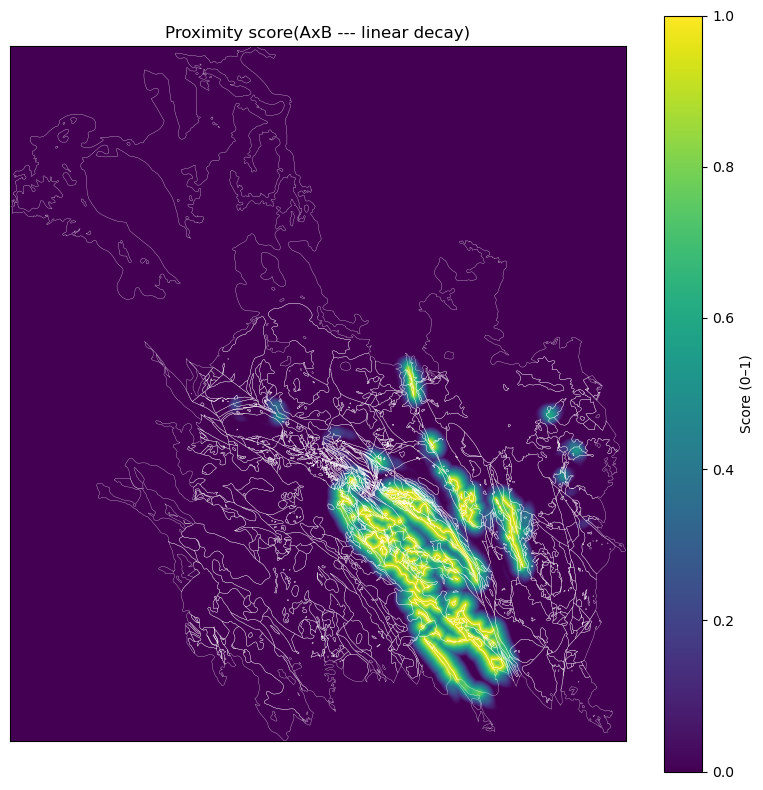

In [13]:
# ----------- Run the program -----------
summary = make_heatmap(
    input_path=INPUT,
    out_tif=OUT_TIF,
    out_png=OUT_PNG,
    pattern_a=PATTERN_A,
    pattern_b=PATTERN_B,
    res_m=RES_M,
    decay_m=DECAY_M,
    crs_epsg=CRS_EPSG,
    #land_path=LAND_PATH,
    text_cols_all=TEXT_COLS_ALL,
    text_cols_b=TEXT_COLS_B,
    nodata_val=NODATA_VAL
)

In [14]:
#print(summary)

## Summary of Heatmap Run  

This block converts the returned `summary` dictionary into a DataFrame for easier visualization.  
It shows key metadata such as grid dimensions, resolution, CRS, min/max scores, and output file paths.  

In [15]:
import pandas as pd
from IPython.display import display

summary_df = pd.DataFrame(list(summary.items()), columns=["Parameter", "Value"])
display(summary_df)


,Parameter,Value
0,grid,"(1617, 1824)"
1,resolution_m,250
2,decay_m,10000
3,crs,26910
4,min_score,0.0
5,max_score,0.99999
6,out_tif,D:\DS_kokold\DS_Kobold_Takehome_Assignment_Dat...
7,out_png,D:\DS_kokold\DS_Kobold_Takehome_Assignment_Dat...


## Note on Method Choice: Why I Kept the Simple Per-Pixel Version (and What I’d Use in Production)

I used the `per-pixel`, `vector-distance` approach in this notebook because it is didactic: it exposes the core idea (distance to Group A and Group B -> decay -> combination) in a way that’s easy to read, reason about, and debug step-by-step.  
For a `production` pipeline on large areas, I would switch to a **rasterized Euclidean Distance Transform (EDT)** workflow, which is much faster and more scalable.

### Why this method here?
- *Transparency:* The loop shows exactly how a score at a cell is computed from distances to A/B.  
- *Concept first:* It makes the *geometry -> distance -> decay -> aggregation* logic explicit.  
- *Ease of explaning:* Each step can be inspected (e.g., try a single row/col, print intermediate distances, change `decay_m` and observe effects).  
- *One-to-one with the formula:** With `α = β = 1`, the implementation mirrors the math:  
  score = max(0,1-d_A/D) x max(0,1-d_B/D)

### What I would use in production (faster, scalable)
A **raster-first** pipeline using the **Euclidean Distance Transform (EDT)**:

1. *Regex tagging (A/B)* on attributes (vector).  
2. *Rasterize* groups A and B to a grid (`res_m`) -> binary masks (1=inside group, 0=elsewhere).  
3. *EDT* on each mask to get *distance-to-group* per cell (in pixels), then convert to meters (`distance_px * res_m`).  
4. *Apply decay* (e.g., linear: `f = clip(1 - d/D, 0, 1)`).  
5. *Aggregate* (e.g., product with optional weights `α`, `β`). Combine two values into a single score using a weighted product: (x^α) * (y^β).
6. *Export* GeoTIFF + PNG.

**Why this is better for large jobs**
- *Speed:* No Python loops over pixels; EDT + NumPy ops run in compiled code (C).  
- *Scalability:* Handles large rasters gracefully; performance is typically orders of magnitude faster.  
- *Stability & reproducibility:* Entirely array-based; fewer geometry edge-cases after rasterization.

### Trade-offs
- *Rasterization vs. vector exactness:* EDT works on the raster grid; the effective accuracy depends on `res_m`. Finer resolution -> more precise (but larger data).  
- *Memory:* Very fine grids increase memory usage; tune `res_m` accordingly.  
- *Behavior at boundaries:* Unioning geometries before rasterization reduces slivers; `all_touched=False` keeps masks conservative.  
- *CRS:* A *projected CRS in meters* is still mandatory (distance-based logic).

### When to choose which
- *Teaching, notebooks, small AOIs:* Per-pixel vector distances are fine and very *illustrative*.  
- *Batch runs, country/region scale, iterations:* Prefer *raster + EDT* for *speed* and *robustness*.

### Extensions I would enable in the EDT path
- *Alternative decays:* Gaussian/RBF (`exp(-(d/σ)^2)`) for smoother halos.  
- *Alternative aggregations:* Harmonic mean if you want different interplay between A and B.  
- *Weights (`α`, `β`):* Emphasize one group if geologically more diagnostic.  
- *Optional masks:* Land/permit boundaries to restrict output area.

**Note:** If this were a **production tool**, I’d switch to the **EDT** workflow for **performance** and **scalability**, while preserving the same geologic logic and outputs (GeoTIFF + PNG + summary).


**End of Notebook**

**Thanks for your attention!**  
**Merci pour votre attention !**  